In [1]:
# !pip install seaborn
# !pip install shap
# !pip install quantus

In [1]:
import pickle

import torch
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from shap import KernelExplainer
import quantus as qt

from pnpxai.explainers import KernelShap, Lime, LRP, IntegratedGradients
import qt_wrapper as qtw
from model import TabResNet, TorchModel

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
# Load test data
with open("data/baf/preprocess/X_test.npy", 'rb') as f:
    X_test = np.load(f)

with open("data/baf/preprocess/y_test.npy", 'rb') as f:
    y_test = np.load(f)

test_df = pd.read_csv("data/baf/preprocess/test.csv", index_col=0)

# Load meta data
with open("data/baf/preprocess/metadata.pkl", 'rb') as f:
    meta = pickle.load(f)

In [4]:
# Load models

with open("models/baf/model_lr.pkl", 'rb') as f:
    model_lr = pickle.load(f)

with open("models/baf/model_rf.pkl", 'rb') as f:
    model_rf = pickle.load(f)

with open("models/baf/model_xgb.pkl", 'rb') as f:
    model_xgb = pickle.load(f)

model_lr_torch = TorchModel(model_lr)
model_rf_torch = TorchModel(model_rf)
model_xgb_torch = TorchModel(model_xgb)
    
model_nn = TabResNet(X_test.shape[1], 2)
model_nn.load_state_dict(torch.load("models/baf/tabresnet.pth"))
model_nn = torch.nn.Sequential(model_nn, torch.nn.Softmax(dim=1))
model_nn.eval()
pass

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [5]:
X_batch = X_test[:10]

In [ ]:
dataset = torch.utils.data.TensorDataset(torch.tensor(X_batch, dtype=torch.float32))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=X_batch.shape[0], shuffle=False)
X = next(iter(dataloader))[0]
# target = model_nn(X).detach()
target = model_lr_torch(X).detach()

In [7]:
def explain_func(model, inputs, targets):
    # Explain models
    inputs = torch.tensor(inputs, dtype=torch.float32)
    targets = torch.tensor(targets, dtype=torch.long)
    explainer = KernelShap(model)
    baselines = torch.zeros(inputs.shape[1])

    attr = explainer.attribute(
        inputs=inputs,
        targets=targets,
        baselines=baselines,
        n_samples=400,
        feature_mask=torch.arange(X.shape[1]).unsqueeze(0),
    ).numpy()

    return attr


metric = qt.Continuity(
    nr_steps=10,
    patch_size=1,
    perturb_baseline=0,
)

score = metric(model_nn, x_batch=X.numpy(), y_batch=target.argmax(dim=1).numpy(), explain_func=explain_func)

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/captum/attr/_core/lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [7]:
# bg_data = np.zeros((1, X_test.shape[1]))
# explainer = KernelExplainer(model_lr.predict_proba, bg_data, link="logit")
# shap_values = explainer.shap_values(X_batch, nsamples=1000)

In [8]:
# def explain_func(model, inputs, targets):
#     # Explain models
#     explainer = KernelExplainer(model_lr.predict_proba, X_batch, link="logit")
#     shap_values = explainer.shap_values(inputs, nsamples=1000)
#     attr = shap_values[np.arange(shap_values.shape[0]), :, targets]

#     return attr

# metric = qtw.Infidelity(
#     loss_func="mse", 
#     perturb_patch_sizes=[1],
#     n_perturb_samples=10,
#     perturb_baseline=0,
# )


    
# wrapper = TorchModel(model_lr)
# wrapper.eval()

# score = metric(wrapper, x_batch=X_batch, y_batch=target, explain_func=explain_func)

In [9]:
# np_score = np.array(score)
# ext = np.percentile(np_score, 99)
# np_score[np_score > ext] = ext
# plt.bar(np.arange(np_score.shape[0]), np_score)

In [6]:
dataset = torch.utils.data.TensorDataset(torch.tensor(X_batch, dtype=torch.float32))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=X_batch.shape[0], shuffle=False)
X = next(iter(dataloader))[0]
# target = model_nn(X).detach()
target = model_lr_torch(X).detach()

In [21]:
# Explain models
shap = KernelShap(model_lr_torch)
baselines = torch.zeros(X.shape[1])

shap_values_lr = shap.attribute(
    inputs=X,
    targets=target.argmax(dim=1),
    baselines=baselines,
    n_samples=400,
    feature_mask=torch.arange(X.shape[1]).unsqueeze(0),
)

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/captum/attr/_core/lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(


In [22]:
# Explain models
lime = Lime(model_lr_torch)
baselines = torch.zeros(X.shape[1])

lime_values_lr = lime.attribute(
    inputs=X,
    targets=target.argmax(dim=1),
    baselines=baselines,
    n_samples=400,
    feature_mask=torch.arange(X.shape[1]).unsqueeze(0),
)

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/captum/attr/_core/lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(


In [25]:
lime_values_lr[0]

tensor([ 0.0187,  0.0568,  0.0000,  0.0000,  0.0283,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000, -0.0126,  0.0000,  0.0000,  0.0000,  0.0159,  0.0290,
         0.0000,  0.0000,  0.0012,  0.0000,  0.0000,  0.0000, -0.0435,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0457,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1459,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0258,  0.0000, -0.1097,  0.0000,
         0.0000,  0.0000,  0.0000])

In [24]:
shap_values_lr

tensor([[ 0.0606,  0.0847,  0.0201,  ..., -0.0006, -0.0005, -0.0036],
        [ 0.0323,  0.0703, -0.0200,  ...,  0.0022, -0.0029,  0.0006],
        [-0.0168, -0.0215, -0.0109,  ...,  0.0266,  0.0005,  0.0046],
        ...,
        [-0.0774,  0.0235,  0.0247,  ...,  0.0148,  0.0008,  0.0053],
        [-0.0104,  0.0584, -0.0249,  ...,  0.0569, -0.0046,  0.0026],
        [-0.0300,  0.0172,  0.0106,  ..., -0.0009, -0.0014, -0.0008]])

In [ ]:
STOP

In [11]:
# Explain models
shap = KernelShap(model_nn)
baselines = torch.zeros(X.shape[1])

shap_values_lr = shap.attribute(
    inputs=X,
    targets=target.argmax(dim=1),
    baselines=baselines,
    n_samples=400,
    feature_mask=torch.arange(X.shape[1]).unsqueeze(0),
)

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/captum/attr/_core/lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(


In [12]:
# Explain models
lime = Lime(model_nn)
baselines = torch.zeros(X.shape[1])

lime_values_lr = lime.attribute(
    inputs=X,
    targets=target.argmax(dim=1),
    baselines=baselines,
    n_samples=400,
    feature_mask=torch.arange(X.shape[1]).unsqueeze(0),
)

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/captum/attr/_core/lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(


In [13]:
lrp = LRP(model_nn)
lrp_values_lr = lrp.attribute(
    inputs=X,
    targets=target.argmax(dim=1),
)

In [14]:
ig = IntegratedGradients(model_nn)
baselines = torch.zeros(X.shape[1])

ig_values_lr = ig.attribute(
    inputs=X,
    targets=target.argmax(dim=1),
)

In [15]:
if not isinstance(shap_values_lr, np.ndarray):
    shap_values_lr = shap_values_lr.detach().numpy()
    
feature_names = meta["float_cols"].tolist() + list(meta["cat_cols"].keys())
res = pd.DataFrame(index=np.arange(X.shape[0]), columns=feature_names)

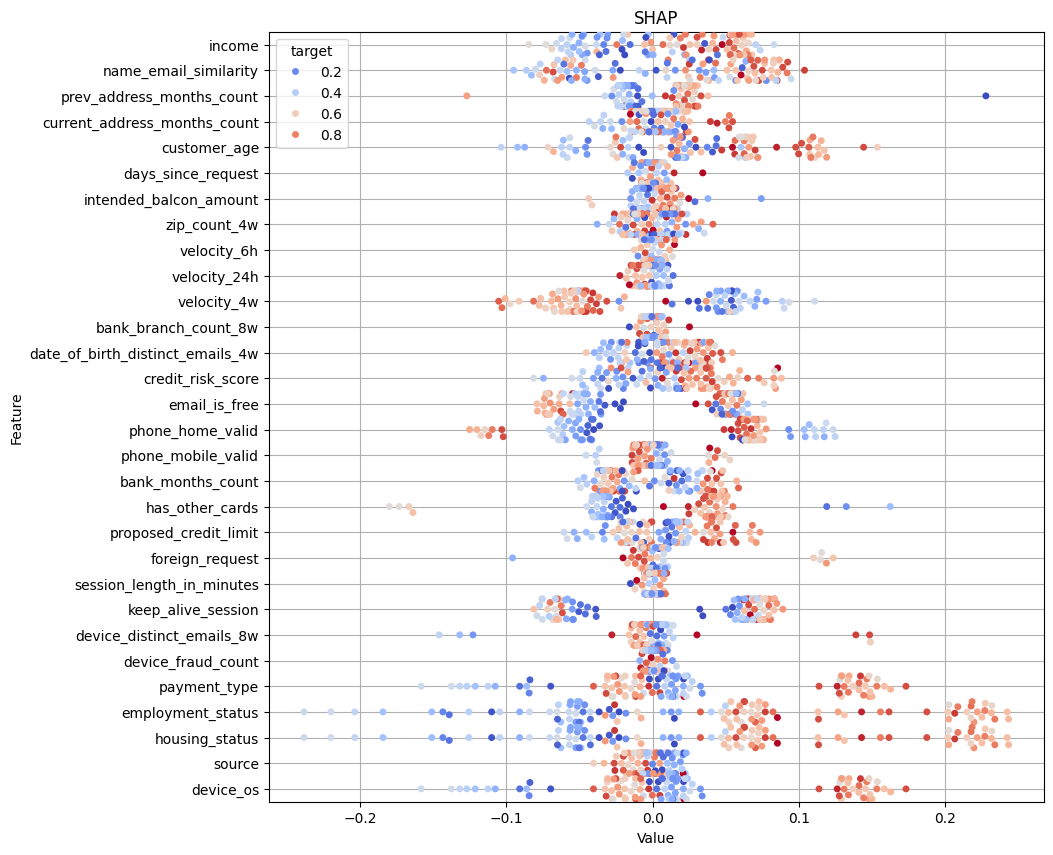

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 96.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 94.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 93.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 92.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/cwl/miniconda3/envs/pn

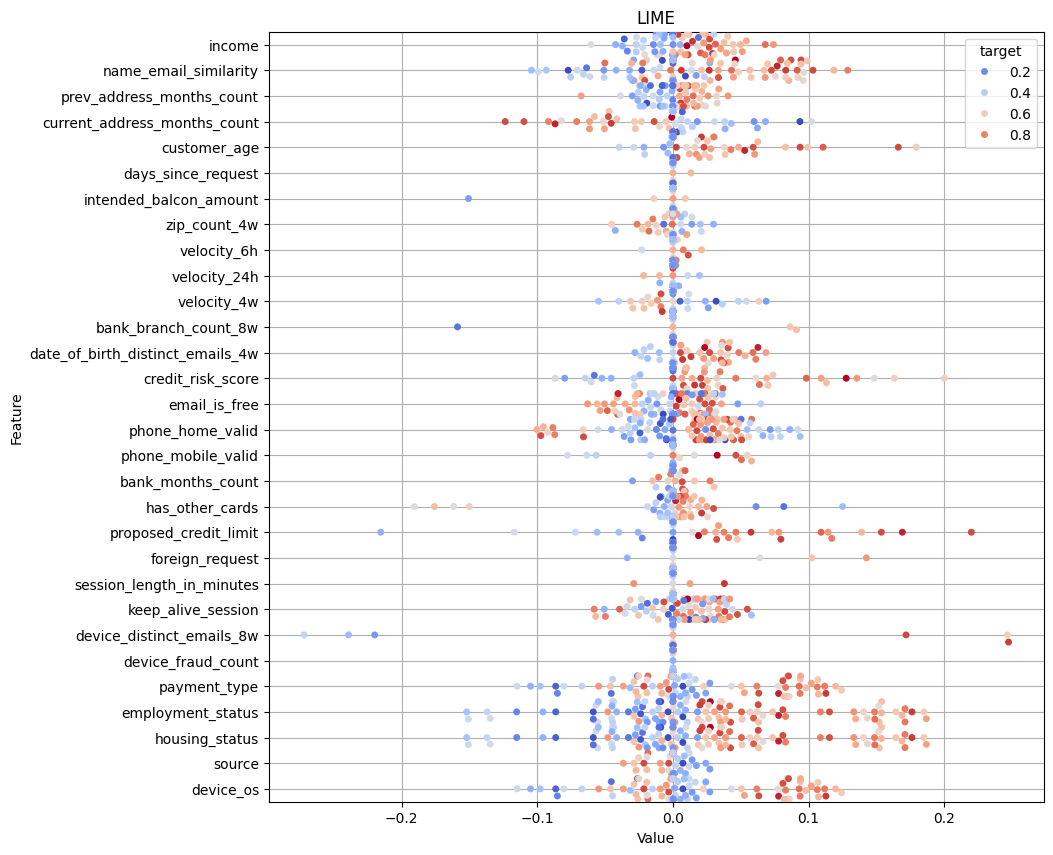

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 97.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


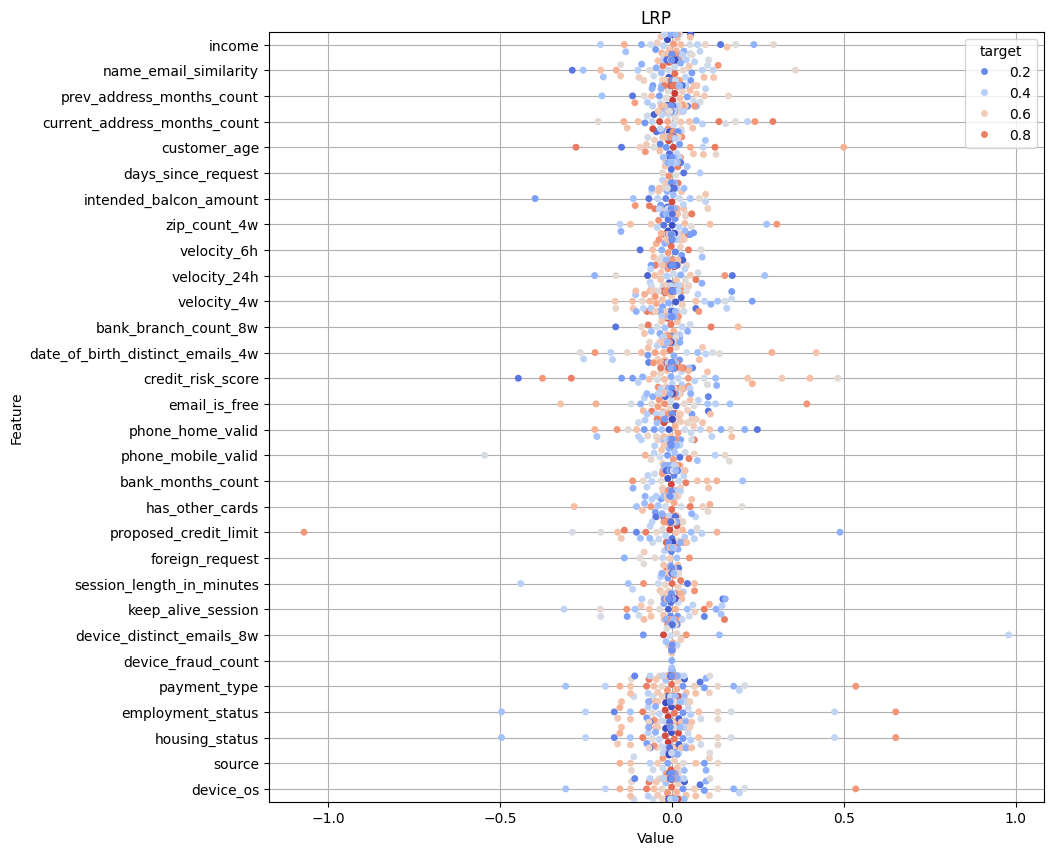

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 92.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 93.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 91.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 94.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/cwl/miniconda3/envs/pn

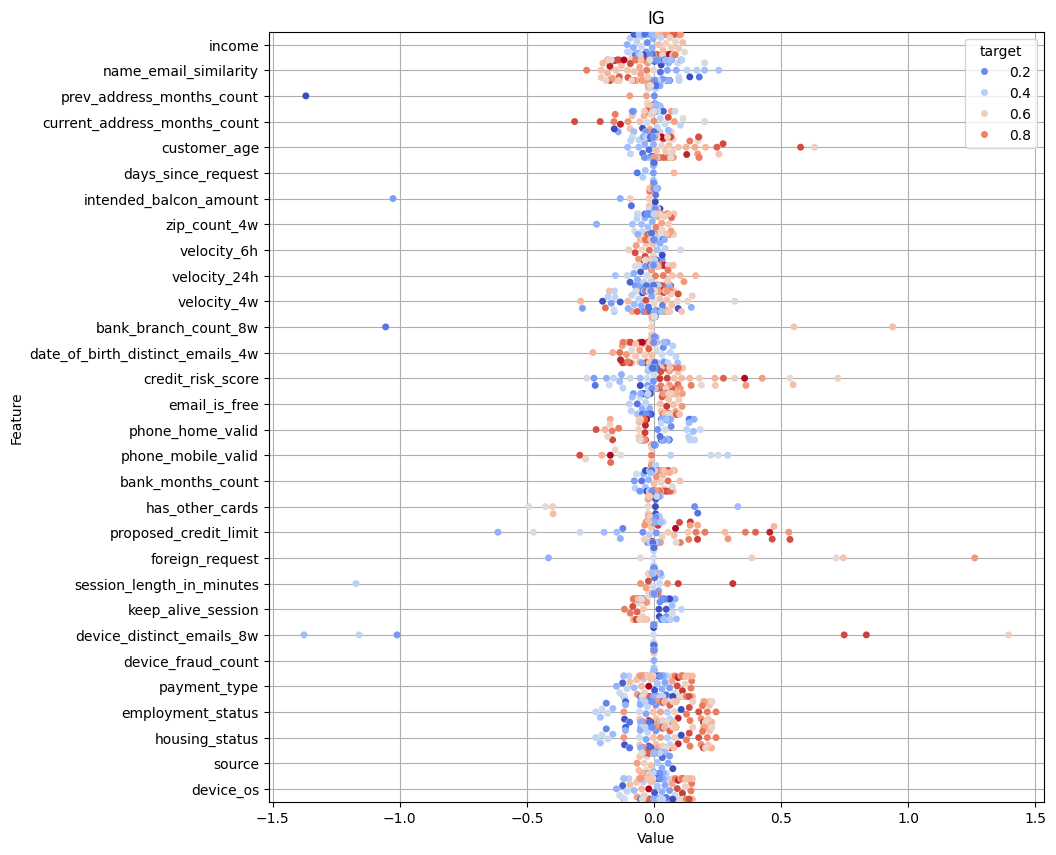

In [16]:
# Colormap with viridis

for explanation, name in zip(
    [shap_values_lr, lime_values_lr, lrp_values_lr, ig_values_lr], ["SHAP", "LIME", "LRP", "IG"]):

    res.loc[:, meta["float_cols"]] = explanation[:, :len(meta["float_cols"])]
    start = len(meta["float_cols"])
    for col in meta['cat_cols'].keys():
        res.loc[:, col] = explanation[:, start:start + len(meta['cat_cols'][col])].sum(axis=1)


    plt.figure(figsize=(10, 10))
    plt.title(name)

    # Melt the DataFrame
    df_melted = res.melt(var_name='Feature', value_name='Value')

    # Convert values to numeric, coercing errors
    df_melted['Value'] = pd.to_numeric(df_melted['Value'], errors='coerce')

    # Add the 'target' column back to the melted DataFrame
    df_melted['target'] = np.tile(target[:, 1], res.shape[1])

    sns.swarmplot(
        data=df_melted,
        x='Value',
        y='Feature',
        hue='target',
        orient="h", size=5, palette="coolwarm", warn_thresh=0.9
    )

    plt.grid()
    plt.show()

In [17]:
from shap.plots import waterfall
from shap import Explanation

In [18]:
# Colormap with viridis
feature_names = meta["float_cols"].tolist() + list(meta["cat_cols"].keys())
res = pd.DataFrame(index=np.arange(X.shape[0]), columns=feature_names)

explanation = shap_values_lr
res.loc[:, meta["float_cols"]] = explanation[:, :len(meta["float_cols"])]
start = len(meta["float_cols"])
for col in meta['cat_cols'].keys():
    res.loc[:, col] = explanation[:, start:start + len(meta['cat_cols'][col])].sum(axis=1)

idx = 6
fx = target[idx, 1].item()
exp = Explanation(
    res.loc[[idx]].values,
    base_values=np.array([fx-res.loc[[idx]].values.sum()]),
    data=test_df[meta["float_cols"].tolist() + list(meta["cat_cols"].keys())].iloc[idx].astype(str).values.reshape(1, -1),
    feature_names=feature_names,
)

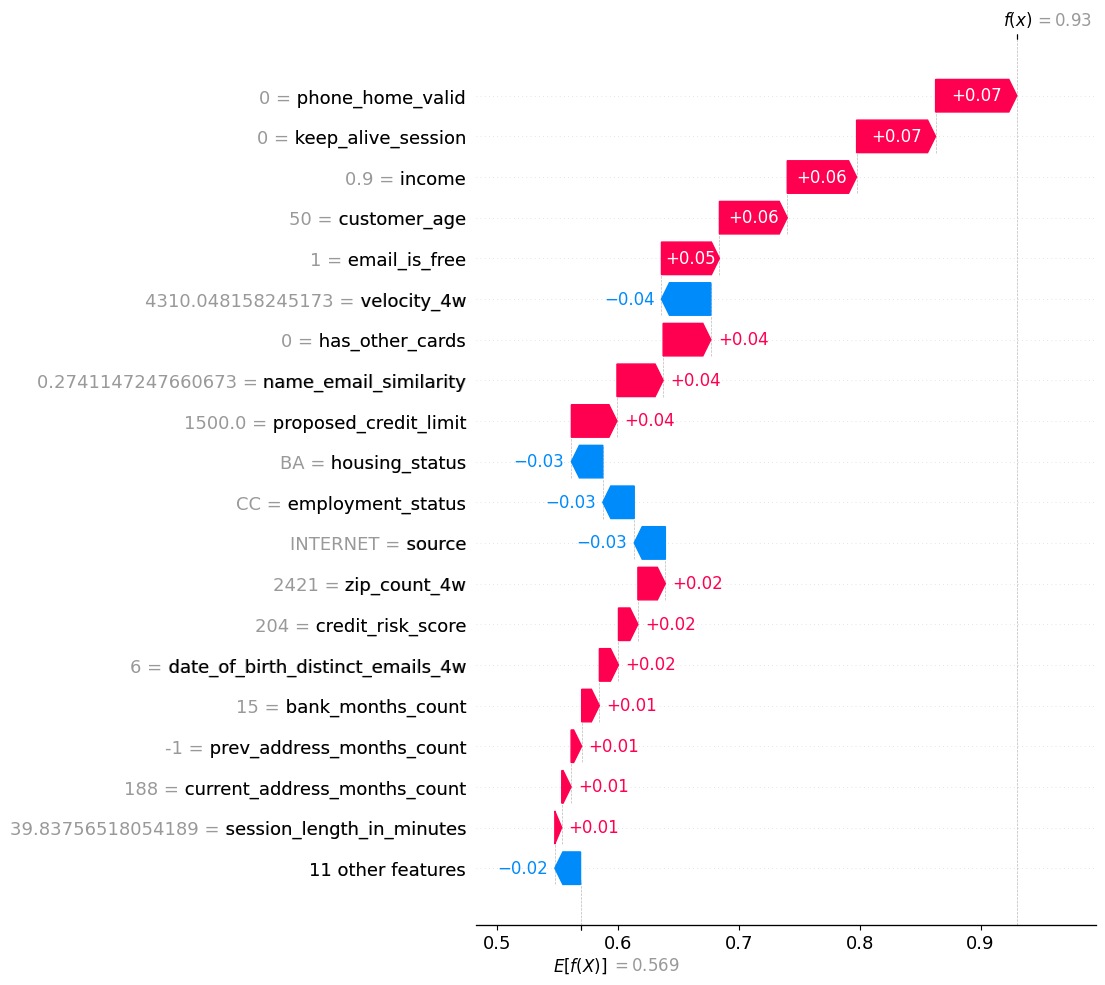

In [19]:
waterfall(exp[0], max_display=20)

In [20]:
def explain_func(model, inputs, targets):
    # Explain models
    inputs = torch.tensor(inputs, dtype=torch.float32)
    targets = torch.tensor(targets, dtype=torch.long)
    explainer = KernelShap(model)
    baselines = torch.zeros(inputs.shape[1])

    attr = explainer.attribute(
        inputs=inputs,
        targets=targets,
        baselines=baselines,
        n_samples=400,
        feature_mask=torch.arange(X.shape[1]).unsqueeze(0),
    ).numpy()

    return attr


metric = qtw.Infidelity(
    loss_func="mse", 
    perturb_patch_sizes=[1],
    n_perturb_samples=10,
    perturb_baseline=0,
)

score = metric(model_nn, x_batch=X.numpy(), y_batch=target.argmax(dim=1).numpy(), explain_func=explain_func)

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/captum/attr/_core/lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
metric = qt.RegionPerturbation(
    patch_size=1, 
    order="morf",
    perturb_baseline=0,
    abs=False,
    normalise=False,
)

morf = metric(model_nn, x_batch=X.numpy(), y_batch=target.argmax(dim=1).numpy(), explain_func=explain_func, softmax=False)

metric = qt.RegionPerturbation(
    patch_size=1, 
    order="lerf",
    perturb_baseline=0,
    abs=False,
    normalise=False,
)

lerf = metric(model_nn, x_batch=X.numpy(), y_batch=target.argmax(dim=1).numpy(), explain_func=explain_func, softmax=False)
morf = -np.array(morf)
lerf = -np.array(lerf)

/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/captum/attr/_core/lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/quantus/helpers/model/pytorch_model.py:135: UserWarning: The combination of the value of the passed softmax argument and the passed model potentially requires adjusting the model's modules. Make sure that the torch.nn.Softmax layer is the last module in the list of model's children (self.model.modules()) if and only if it is the actual last module applied beforeoutput.
  warnings.warn(
/home/cwl/miniconda3/envs/pnpenv/lib/python3.10/site-packages/quantus/helpers/warn.py:161: UserWarning: The number of non-overlapping patches (51) for this input and attributionis lower than the 

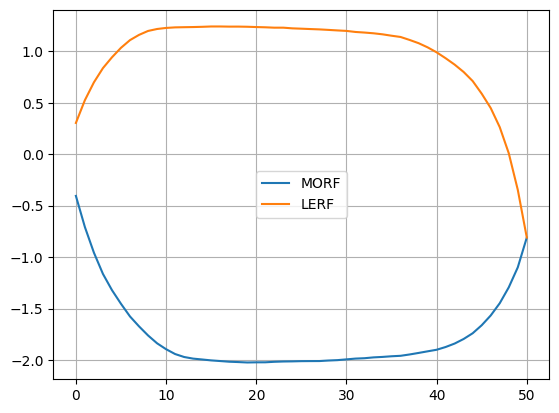

In [ ]:
plt.plot(morf.mean(axis=0), label="MORF")
plt.plot(lerf.mean(axis=0), label="LERF")
plt.grid()
plt.legend()
plt.show()

In [ ]:
morf.shape

(400, 51)